In [96]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from runs import find_runs  # noqa: E402

### Load data and calculate error

In [97]:
def load_data(runs_dir: pathlib.Path) -> pd.DataFrame:
    """Load the data from the runs in the given directory.
    Calculate the position error between timestep 0 and 2000

    Args:
        runs_dir: The directory containing the runs.
        timestep: The timestep to load.

    Return:
        A pandas DataFrame containing the data. The index is the grid spacing and
        the columns are the different mappings.
    """

    # Find the runs, we are interested in
    runs = find_runs(runs_dir)

    # Load the data
    data = {}  # Raw data: {grid_spacing: {timestep: error_value}}

    for run_path in runs:
        # Read parameters of the run
        with open(run_path / "parameters.json") as file:
            parameters = json.load(file)

        # Calculate grid spacing from refinement level
        grid_spacing = 1 / 2 ** parameters["refinement"]

        # Calculate position error
        try:
            file_name_begin = f"refinement-{parameters['refinement']}_particles_000000.pvtu"
            file_name_end = f"refinement-{parameters['refinement']}_particles_999999.pvtu"

            mesh_begin = pv.read(run_path / "solution" / file_name_begin)
            mesh_end = pv.read(run_path / "solution" / file_name_end)

            mesh_end["error"] = np.linalg.norm(mesh_begin.points - mesh_end.points, axis=1)

            mean_error = mesh_end["error"].mean()

        except Exception:
            mean_error = np.nan

        # Insert error into data dict
        if grid_spacing not in data:
            data[grid_spacing] = {}
        data[grid_spacing][parameters["time_step"]] = mean_error

    # Convert data dict to pandas DataFrame
    return (
        pd.DataFrame(data)
        .sort_index(axis=0, ascending=False)
        .sort_index(axis=1, ascending=False)
    )


df = load_data(working_dir.parent / "runs" / "euler_explicit" / "nearest-neighbor")
df

,0.250000,0.062500,0.015625,0.003906
0.500000,NaN,0.260858,0.258519,0.258392
0.250000,0.292019,0.216326,0.216795,0.216567
0.125000,0.243602,0.186617,0.184623,0.183320
0.062500,0.158641,0.134391,0.131935,0.131749
0.031250,0.115625,0.103308,0.101239,0.101674
0.015625,0.090847,0.080461,0.078815,0.078502
0.007812,0.077906,0.064698,0.059617,0.061928
0.003906,0.071293,0.048836,0.045677,0.045274
0.001953,0.066334,0.040137,0.031828,0.032269
0.000977,0.062833,0.031487,0.018320,0.018253


### Tracking error vs. time step 

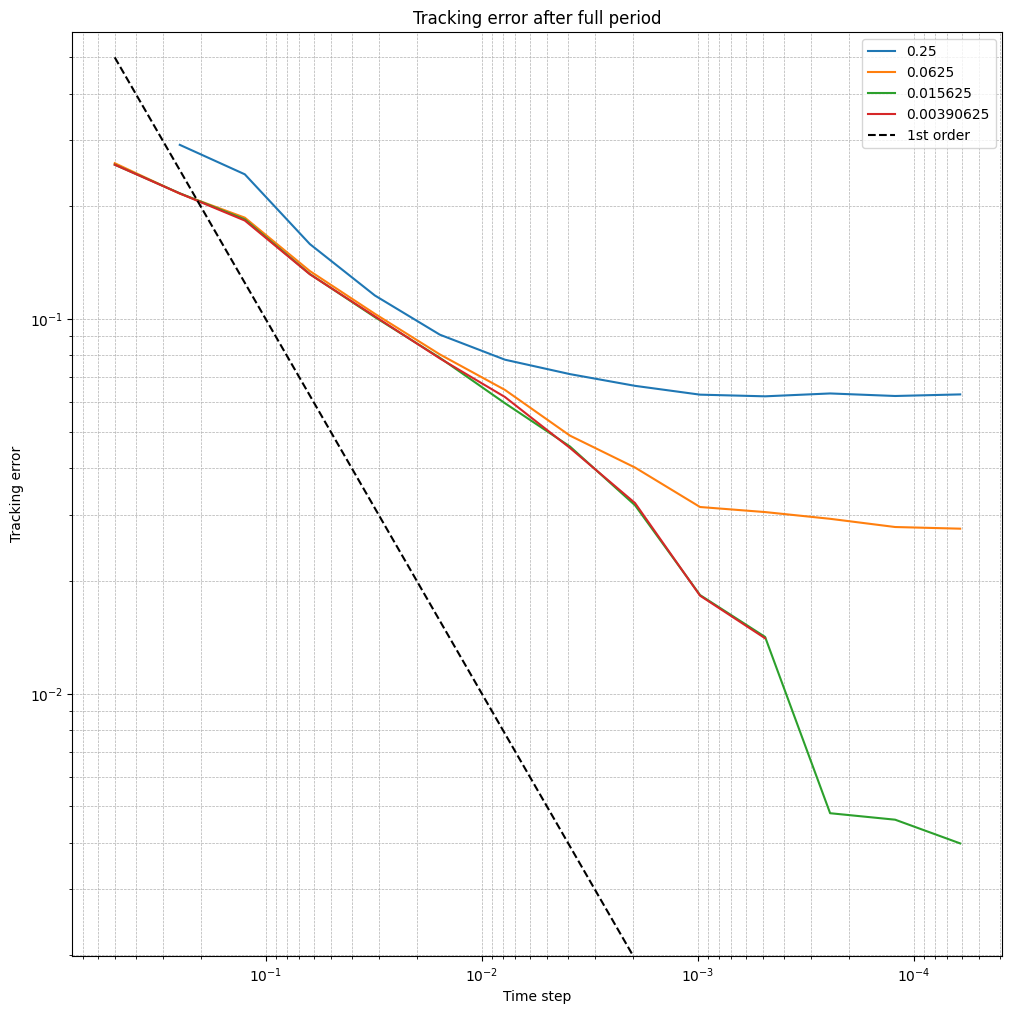

In [98]:
from matplotlib.axes import Axes


def plot_error_vs_time_step(data: pd.DataFrame, title: str, reference_lines = True, ax: Axes = None):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        fig
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
        ax: The axes to plot on. If None, create a new figure and axes.
    """

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the data
    for column in data.columns:
        ax.plot(data.index, data[column], label=column)
    
    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="--", color="black", label="1st order")
        # Second order convergence
        # ax.plot(data.index, data.index ** 2, linestyle="--", color="black", label="2nd order")

    # Add labels and legend
    ax.set_title(title)
    ax.legend()
    ax.grid(which="both", linestyle="--", linewidth=0.5)

    # Configure axes
    ax.set_xlabel("Time step")
    ax.set_xscale("log")
    ax.invert_xaxis()
    
    ax.set_ylabel("Tracking error")
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)

plot_error_vs_time_step(df, "Tracking error after full period")


### Tracking error vs. grid spacing

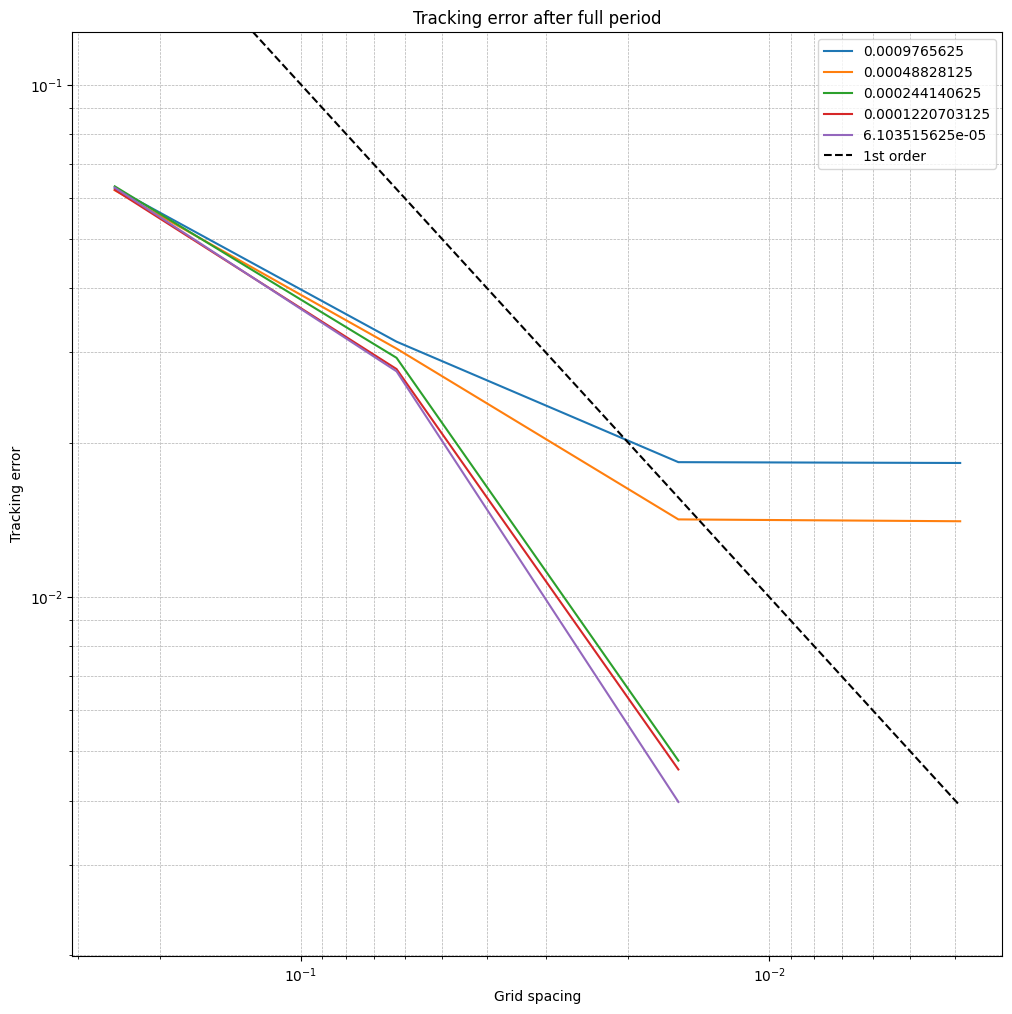

In [99]:
def plot_error_vs_grid_spacing(data: pd.DataFrame, title: str, reference_lines = True, ax: Axes = None):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        fig
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
        ax: The axes to plot on. If None, create a new figure and axes.
    """

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    data = data.T

    # Plot the data
    for column in data.columns:
        ax.plot(data.index, data[column], label=column)
    
    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="--", color="black", label="1st order")
        # Second order convergence
        # ax.plot(data.index, data.index ** 2, linestyle="--", color="black", label="2nd order")

    # Add labels and legend
    ax.set_title(title)
    ax.legend()
    ax.grid(which="both", linestyle="--", linewidth=0.5)

    # Configure axes
    ax.set_xlabel("Grid spacing")
    ax.set_xscale("log")
    ax.invert_xaxis()
    
    ax.set_ylabel("Tracking error")
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)

plot_error_vs_grid_spacing(df[df.index < 0.001], "Tracking error after full period")

### Interaction between grid spacing and time step

In [100]:
df

,0.250000,0.062500,0.015625,0.003906
0.500000,NaN,0.260858,0.258519,0.258392
0.250000,0.292019,0.216326,0.216795,0.216567
0.125000,0.243602,0.186617,0.184623,0.183320
0.062500,0.158641,0.134391,0.131935,0.131749
0.031250,0.115625,0.103308,0.101239,0.101674
0.015625,0.090847,0.080461,0.078815,0.078502
0.007812,0.077906,0.064698,0.059617,0.061928
0.003906,0.071293,0.048836,0.045677,0.045274
0.001953,0.066334,0.040137,0.031828,0.032269
0.000977,0.062833,0.031487,0.018320,0.018253


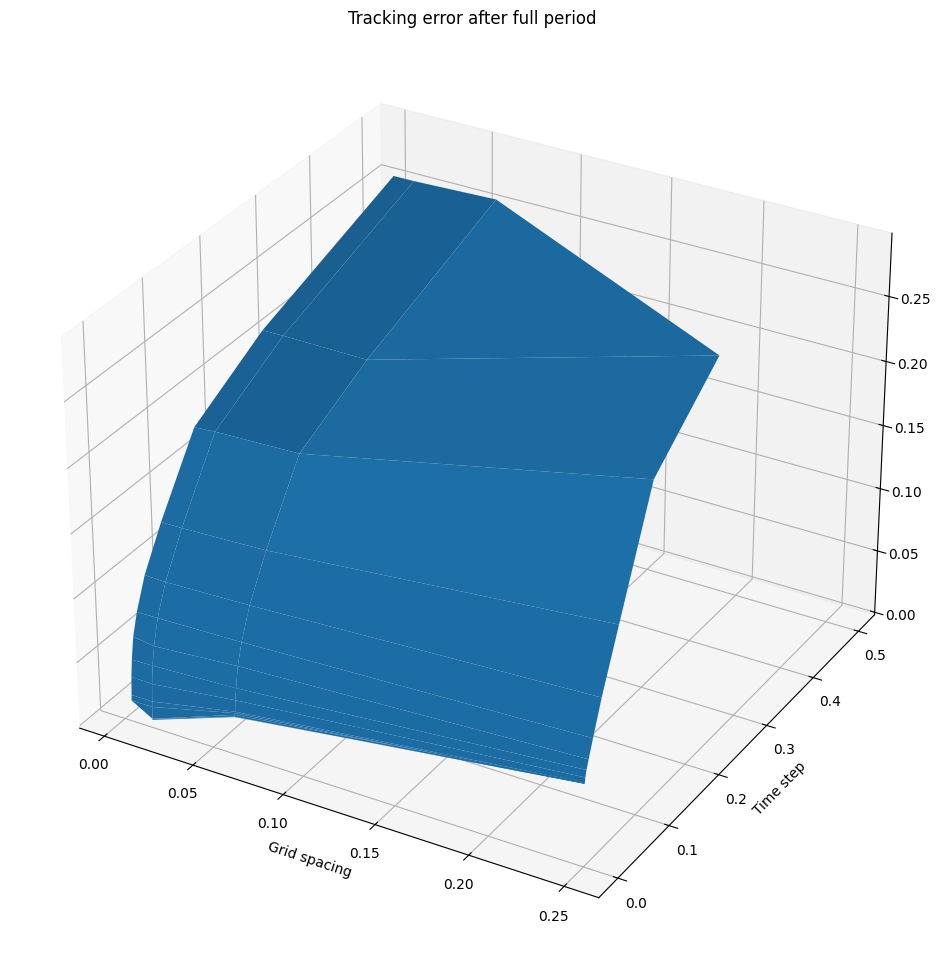

In [101]:
X = [float(c) for c in df.columns]
Y = [float(i) for i in df.index]
X, Y = np.meshgrid(X, Y)
Z = df.values

# Plot the surface
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z)

# Add labels and legend
ax.set_title("Tracking error after full period")
ax.grid(which="both", linestyle="--", linewidth=0.5)

# # Configure axes
ax.set_xlabel("Grid spacing")
# ax.set_xscale("log")
# ax.invert_xaxis()

ax.set_ylabel("Time step")
# ax.set_yscale("log")

# ax.set_zscale("log")

plt.show()

### Compare methods

FileNotFoundError: [Errno 2] No such file or directory: '/home/robin/uni/ba-repo/deal.II-example-step-68-with-preCICE/runs/euler_implicit'

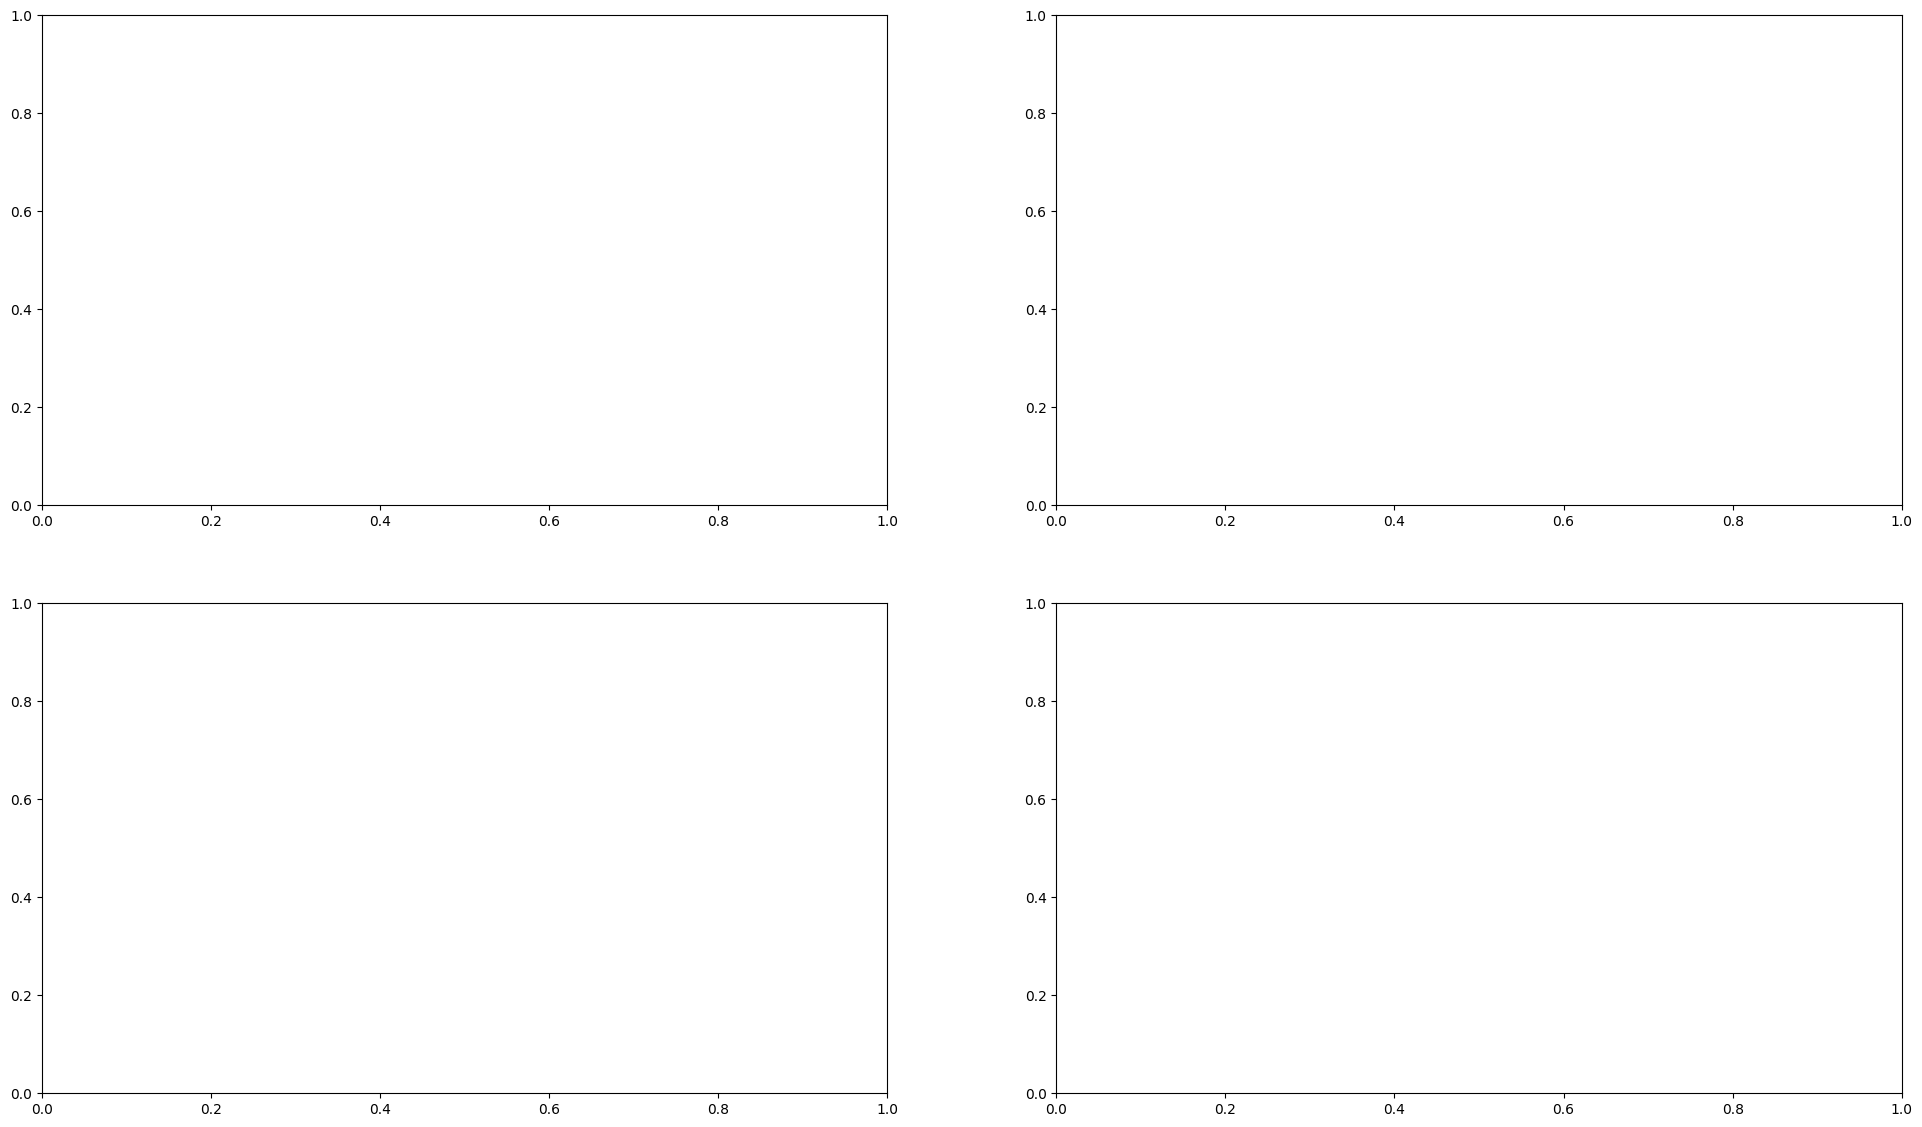

In [102]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 14))

euler_explicit = load_data(working_dir.parent / "runs" / "euler_explicit")
euler_implicit = load_data(working_dir.parent / "runs" / "euler_implicit")
# trapezoidal = load_data(working_dir.parent / "runs" / "trapezoidal")

plot_error_vs_time_step(
    euler_explicit,
    title="explicit euler",
    ax=ax[0][0],
)
plot_error_vs_time_step(
    euler_implicit,
    title="implicit euler",
    ax=ax[0][1],
)
# plot_error_convergence(
#     trapezoidal,
#     title="trapezoidal",
#     ax=ax[1][0],
# )

# Calculate global y-axis limits
x_min = min(subplot.get_xlim()[0] for row in ax for subplot in row)
x_max = max(subplot.get_xlim()[1] for row in ax for subplot in row)
y_min = min(subplot.get_ylim()[0] for row in ax for subplot in row)
y_max = max(subplot.get_ylim()[1] for row in ax for subplot in row)

# Set the same x-axis and y-axis limits for all subplots
for row in ax:
    for subplot in row:
        subplot.set_xlim(x_max, x_min)
        subplot.set_ylim(y_min, y_max)
